# Implementation of the SPT Model - Version 2

Modifications: Johnny Esteves\ Author: Allen Pinjic - Created on June 9th, 2022

In [1]:
from __future__ import print_function, division

import os
import sys
import numpy as np
import emcee

In [2]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo

In [3]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import math

In [118]:
%matplotlib inline

## Prior Values

In [5]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']


## Load the Data

In [6]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
data[:2]

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,RM_PROB,CL_NOTES,M500,M500_UERR,M500_LERR,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF
str16,float64,float64,str11,float32,float32,float32,float32,int16,float32,float32,str50,float32,float32,float32,float32,float32,float32,float32,float32,str38,str19,str29
SPT-CLJ0000-2518,0.072338357,-25.303935,ra1hdec-25,5.073545,1.5,0.0,0.0,0,0.0,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,,
SPT-CLJ0005-3751,1.4383179,-37.854369,ra1hdec-35,6.336327,0.75,0.48295808,0.0072415886,0,4.0,0.00061007956,-,5.419,0.887,0.887,86.40839,4.7352147,0.0,1.0,3.0,,,


In [7]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])
m500 = np.array(data['M500'])*1e14

In [8]:
ix = np.where(lambda_chisq>5)[0] # take 100 points
Np = ix.size

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

print('Npoints:',Np)

Npoints: 298


In [9]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmax(lambda_chisq[lambda_chisq>0])]

lbd_hat_i = lambda_chisq[ix]
lbd_err_i = lambda_chisqE[ix]
chisi_i = sz_signal[ix]
z_i = redshift[ix]
print(lbd_hat_i)
print(chisi_i)

203.78017
10.641013


In [10]:
# test function 
# debuging here
eps  =1e-9
lbd  = lbd_hat[0]
zeta = chisi[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [11]:
y = np.vstack([lbd_hat,chisi])
yerr = lbd_err
x = redshift

In [12]:
np.max(np.log10(m500))

<ipython-input-12-c0309a2e430a>:1: RuntimeWarning: divide by zero encountered in log10
  np.max(np.log10(m500))


15.159748

## Define the Model

### Set Grid Vector

In [13]:
# set up integration vectors
mvec = np.logspace(14.1, 15.25, 40)
lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
zetavec = np.linspace(1,1.1*np.max(sz_signal),75)

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
40
150
75


In [14]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

In [15]:
zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [16]:
hmf_vector = halo_mass_function2(z).T
hmf_vector.shape

(298, 40)

In [17]:
def prob_chisi(zeta, chisi, eps=1e-12):
    res = np.exp(-(chisi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, lbd_hat, lbd_error, eps=1e-12):
    res = gaussian(lbd, lbd_hat, lbd_error)
    return res#np.where(res<eps,0.,res)

# taking only points with a significant p_chisi/lbd_hat
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [18]:
prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i) 
                             for lbd_hat_i, lbd_err_i in zip(lbd_hat, lbd_err)])
prob_chisi_vec = np.array([prob_chisi(zetavec, chisi_i) for chisi_i in chisi])

print(prob_lbd_hat_vec.shape)

(298, 150)


In [19]:
alpha = 0.1
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])

lbd_indices_vec.shape

(298, 2)

## Likelihood

In [289]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)
from numba import njit
@njit
def Ez2(x_vals, x, y):
    return np.interp(x_vals, x, y)

# Ez2 = interpolate.interp1d(zvec, E(zvec), kind='cubic')
yvec = E(zvec)

#Insert the priors on the SZE scaling relation parameters that identify with SZE,
# along with a value for the mass (M) and redshift (z)
## References Equation 2
M0 = 3e14
Ez0 = E(0)
@jit(nopython=True)
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(Ez2(z,zvec,yvec)/Ez0))

#Insert the priors on the SZE scaling relation parameters that identify with LAMBDA, 
# along with a value for the mass (M) and redshift (z)
# Identified with the 
## References Equation 3
@jit(nopython=True)
def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(Ez2(z,zvec,yvec)/Ez0))
@jit(nopython=True)
def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [290]:
from scipy.integrate import simps
from numba import jit

# given: mvec, lbdvec and zetavec
# @jit(nopython=True)
def log_likelihood_vec2(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_log_likelihood2(theta, ix))
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [291]:
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')
# @jit(nopython=False)
def _log_likelihood2(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    z_i = z[ix]
    p_chisi = prob_chisi_vec[ix]
    p_lbd_hat = prob_lbd_hat_vec[ix]
    llo, lup = list(lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    halo_mass_func = hmf_vector[ix]

    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
    
    hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[:,clo:cup,llo:lup],zz[:,clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred, hmf)
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p

In [292]:
@jit(nopython=True)
def compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, hmf, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    s_zeta_inv = np.where(scatter_sze<=s_zeta, -np.inf, 1/s_zeta)
    s_lambda_inv = np.where(s_lambda<=eps, -np.inf, 1/s_lambda)
    
    cov = (scatter_lambda)**(2)*(scatter_sze)**(2)*(1-rho**2)
    additional_cov = (-0.5)*np.log(np.pi*cov**2)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    
    # defining standardized variables
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda_inv
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta_inv
    #np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    p_total_m = (hmf*np.exp(lp_total_m))/(lvec*zvec)
    
    return p_total_m


In [293]:
# Implementing the log_likelihood_vec2 in the emcee code
# via writing to the prior functions.

# In reference to rho's (ρ) defintion it states:
# Parameters of the richness–mass relation defined
# in Eq. 11 (Bleem et al. 2019) 
## and the correlation coefficient, ρSZ−λ, between the SZ signal (ζ) and richness.

# ρ also defined as the correlation coefficient  
# that encodes the degree of correlation between the intrinsic scatters on the respective observables

In [294]:
# @jit(nopython=True)
def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [295]:
logprior(theta)

0.0

In [296]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)

In [309]:
Nburnin = 500 # number of burn-in samples
Nsamples = 1000 # number of final posterior samples
walkers = 32
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
sel = np.arange(len(z))#[:100]
# sel = np.random.randint(len(z), size=100, dtype=int)
argslist = [sel]

In [310]:
logposterior(theta, sel)

-inf

In [311]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_vec2(*args)
initial = theta + 0.2 * np.random.randn(9)
soln = minimize(nll, initial, args=sel)
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

Maximum likelihood estimates:
Albd = 76.853
Blbd = 0.973
Clbd = 0.606
Scatter_lbd = 0.313
rho: 0.706


In [312]:
theta

[5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [313]:
import time
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=[sel])
start = time.time()
sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
end = time.time()
serial_time = end - start
print("Serial Time took {0:.1f} seconds".format(serial_time))
# print("{0:.1f} times faster than serial".format(serial_time / multi_time))

  2%|▏         | 32/1500 [03:24<2:36:23,  6.39s/it]Traceback (most recent call last):
  File "/usr/local/anaconda/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-296-e9befc3bcb9c>", line 9, in logposterior
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)
  File "<ipython-input-290-fe95f8564f6e>", line 10, in log_likelihood_vec2
    probs.append(_log_likelihood2(theta, ix))
  File "<ipython-input-291-5254f6ce4556>", line 25, in _log_likelihood2
    p_total_m = compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
KeyboardInterrupt
  2%|▏         | 32/1500 [03:28<2:39:31,  6.52s/it]

emcee: Exception while calling your likelihood function:
  params: [ 5.19702678  1.55353928  0.45407463  0.16119879 77.10752627  1.02938623
  0.2917591   0.16171432  0.78480996]
  args: [array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145,

KeyboardInterrupt: 

In [106]:
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

In [136]:
2849.1/60

47.485

In [135]:
# from multiprocessing import Pool
# import time

# with Pool(processes = 6) as pool:
#     sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=[sel], pool=pool)
#     start = time.time()
#     sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
#     end = time.time()
#     multi_time = end - start
#     serial_time = (1.5)*(3600)
#     print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#     print("{0:.1f} times faster than serial".format(serial_time / multi_time))

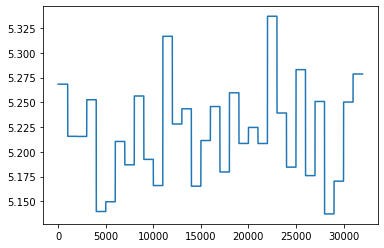

In [129]:

plt.plot(postsamples[:,0])

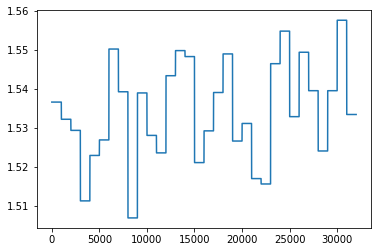

In [130]:
plt.plot(postsamples[:,1])

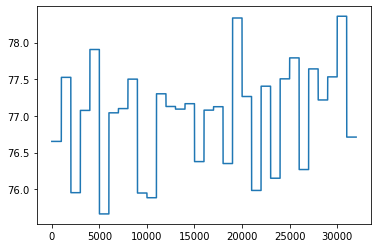

In [131]:
plt.plot(postsamples[:,4])


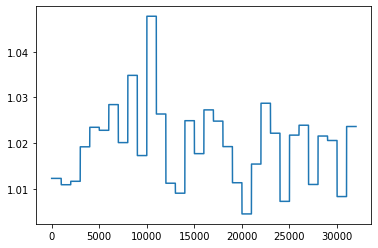

In [132]:
plt.plot(postsamples[:,5])

Number of posterior samples is 32000


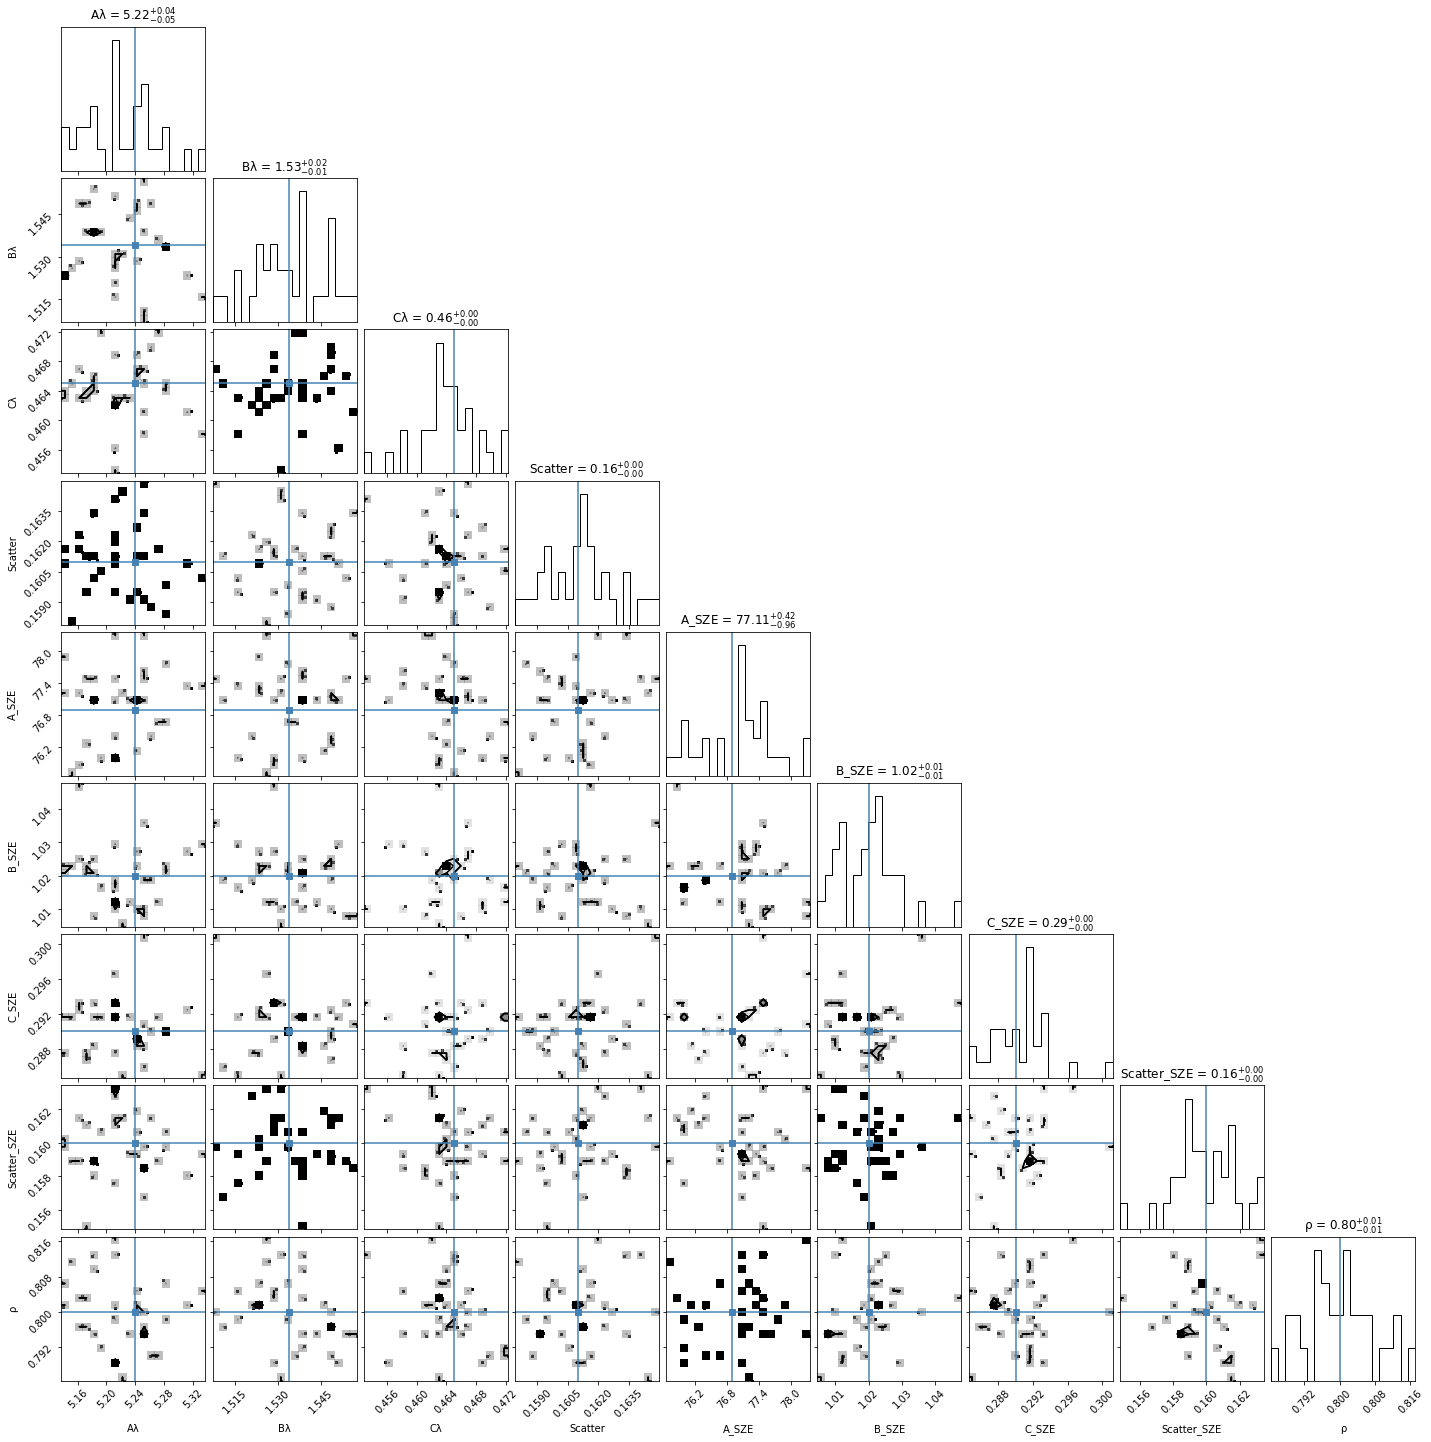

In [134]:
A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

try:
    import matplotlib as mpl
    mpl.use("Agg") # force Matplotlib backend to Agg
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[r"Aλ", r"Bλ", r"Cλ", r"Scatter", r"A_SZE", r"B_SZE", r"C_SZE", r"Scatter_SZE", "ρ"]
                    , show_titles = True, truths=theta)
# plt.show()

In [137]:
np.savetxt('chain0.npy',postsamples)

In [111]:
import pylab as plt


In [ ]:
# set up the sampler
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required
sampler.run_mcmc(guess, Nsamples+Nburnin);

# extract the samples (removing the burn-in)
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

In [ ]:
import os

os.environ.keys()